In [30]:
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import scienceplots

# Prueba con XGBoost

## Función de Bootstrapping para analizar los mejores individuos

In [31]:
def bootstrap_confidence_intervals_df(df, param_cols, fitness_col='fitness', n_bootstrap=1000, alpha=0.05):
    """
    Calcula intervalos de confianza para:
    - la media de los parámetros
    - los parámetros del mejor individuo (fitness mínimo)
    Además imprime las medias bootstrapped.
    """

    # Convertimos a cupy
    poblacion_params = cp.asarray(df[param_cols].values)
    poblacion_fitness = cp.asarray(df[fitness_col].values)

    N, d = poblacion_params.shape
    mean_params_samples = cp.zeros((n_bootstrap, d))
    best_params_samples = cp.zeros((n_bootstrap, d))

    rng = cp.random.default_rng()

    for i in range(n_bootstrap):
        idx = rng.integers(0, N, size=N)
        sample_params = poblacion_params[idx]
        sample_fitness = poblacion_fitness[idx]

        # media de parámetros
        mean_params_samples[i] = sample_params.mean(axis=0)

        # mejores parámetros
        best_idx = cp.argmin(sample_fitness)
        best_params_samples[i] = sample_params[best_idx]

    low_q = 100 * (alpha/2)
    high_q = 100 * (1 - alpha/2)

    mean_params_CI = cp.percentile(mean_params_samples, [low_q, high_q], axis=0)
    best_params_CI = cp.percentile(best_params_samples, [low_q, high_q], axis=0)

    # >>> NUEVO: medias bootstrapped
    mean_params_boot_mean = mean_params_samples.mean(axis=0).get()
    best_params_boot_mean = best_params_samples.mean(axis=0).get()

    mean_df = pd.DataFrame({
        "param": param_cols,
        "low": mean_params_CI[0].get(),
        "high": mean_params_CI[1].get(),
        "boot_mean": mean_params_boot_mean
    })

    best_df = pd.DataFrame({
        "param": param_cols,
        "low": best_params_CI[0].get(),
        "high": best_params_CI[1].get(),
        "boot_mean": best_params_boot_mean
    })

    return {"mean_params_CI": mean_df, "best_params_CI": best_df}

## Experimento 1

In [26]:
# ---------------------------
# 1. Cargar datos
# ---------------------------

# Ruta de la carpeta con los CSV
ruta = "c:/Users/becer/OneDrive/Desktop/Maestría en Ciencias Físicas/Tesis/Incendios-Forestales---MCF-2024-2025/Genetico/resultados/exp1"

# Buscar todos los archivos CSV en la carpeta
archivos_csv = glob.glob(os.path.join(ruta, "*.csv"))

# Leer y concatenar
df = pd.concat((pd.read_csv(archivo) for archivo in archivos_csv), ignore_index=True)

# Features y target
X = df[["D", "A", "B", "x", "y"]] 
y = df["fitness"]

df

,D,A,B,x,y,fitness
0,83.626976,0.000496,21.974182,416.0,496.0,0.845207
1,6.494542,0.000324,1.872564,515.0,503.0,1.323900
2,96.433609,0.000217,17.221539,385.0,574.0,0.537906
3,11.028158,0.000200,11.862853,454.0,554.0,0.749674
4,49.082073,0.000149,15.561389,491.0,560.0,0.876539
...,...,...,...,...,...,...
1009995,16.090879,0.000068,14.927485,408.0,597.0,0.025317
1009996,13.905869,0.000066,15.145274,408.0,597.0,0.037766
1009997,16.116991,0.000069,14.927485,408.0,621.0,0.301520
1009998,15.074011,0.000067,14.953675,407.0,597.0,0.022659


In [27]:
# ---------------------------
# 2. Train / Test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [28]:
# ---------------------------
# 3. Entrenar modelo XGBoost
# ---------------------------
model = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.1,
    tree_method="hist",   # GPU
    device="cuda",
    random_state=42
)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [29]:
# ---------------------------
# 4. Evaluar surrogate
# ---------------------------
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.6f}")
print(f"R²: {r2:.6f}")

MSE: 0.000117
R²: 0.997393


In [30]:
from sklearn.model_selection import cross_val_score, KFold

# Definir la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar R²
r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")
mse_scores = cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")

print("R² promedio:", np.mean(r2_scores), "+/-", np.std(r2_scores))
print("MSE promedio:", -np.mean(mse_scores), "+/-", np.std(mse_scores))

R² promedio: 0.9974611518811349 +/- 4.1467593999821946e-05
MSE promedio: 0.00011401502901372409 +/- 2.1739398220891764e-06


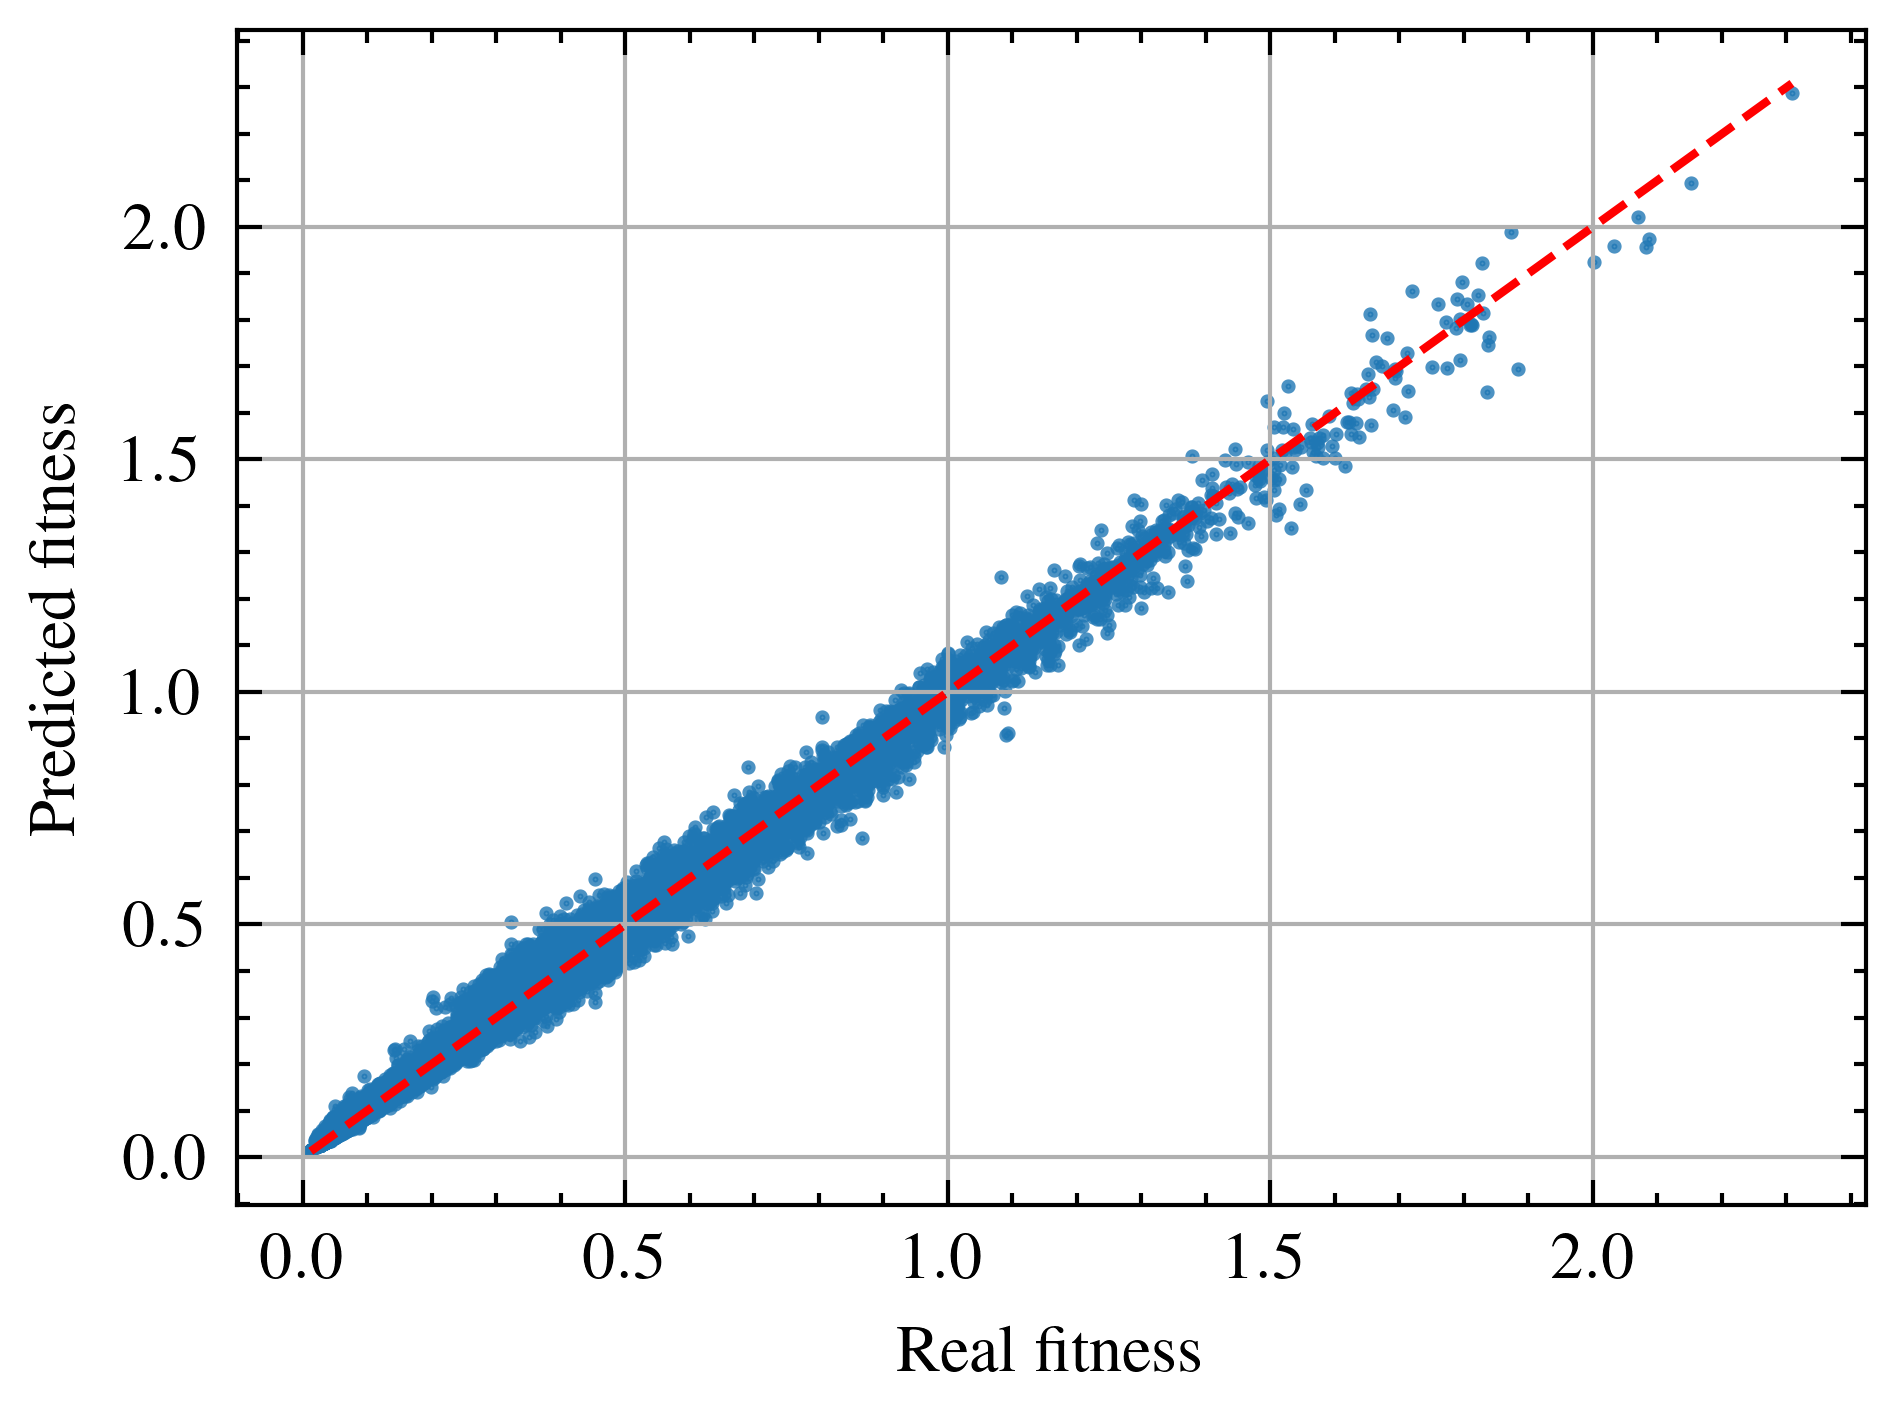

In [ ]:
# 5. Visualización: real vs predicho
plt.style.use(["science", "ieee"])  # activás scienceplots
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=plt.cm.tab10.colors)  # ciclo estándar matplotlib

# ---------------------------
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.8, s=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Real fitness")
plt.ylabel("Predicted fitness")
# plt.xlim(0, 0.1)
# plt.ylim(0, 0.1)
plt.grid()
plt.tight_layout()
plt.savefig("XGBoost_test_exp1.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [9]:
# ---------------------------
# 6. Usar surrogate para explorar
# ---------------------------
# Rango de parámetros según tu dataframe
param_ranges = {
    "D": (df["D"].min(), df["D"].max()),
    "A": (df["A"].min(), df["A"].max()),
    "B": (df["B"].min(), df["B"].max()),
    "x": (df["x"].min(), df["x"].max()),
    "y": (df["y"].min(), df["y"].max()),
}

# Configuración de la búsqueda
N_total = int(1e8)       # total de candidatos a probar (200 millones)
batch_size = int(1e6)    # tamaño del batch (1 millón)
n_batches = N_total // batch_size

k = 20  # top-k por batch
mejores_globales = []

for i in range(n_batches):
    print(f"Batch {i+1}/{n_batches}")

    # Generar candidatos aleatorios dentro de los rangos
    candidatos = np.column_stack([
        np.random.uniform(low, high, batch_size)
        for (low, high) in param_ranges.values()
    ])

    # Predecir fitness con el surrogate model
    preds = model.predict(candidatos)

    # Obtener los mejores índices (menor fitness = mejor)
    top_idx = np.argsort(preds)[:k]

    # Guardar pares (parámetros, fitness)
    for idx in top_idx:
        mejores_globales.append((candidatos[idx], preds[idx]))

# Convertir a array y seleccionar los mejores globales
mejores_globales = sorted(mejores_globales, key=lambda x: x[1])[:50]

# Separar parámetros y fitness
candidatos_finales = np.array([x[0] for x in mejores_globales])
fitness_finales = np.array([x[1] for x in mejores_globales])

print("Top candidatos encontrados:")
for i, (params, fit) in enumerate(zip(candidatos_finales, fitness_finales), 1):
    print(f"{i}: {params}, fitness={fit}")

Batch 1/100
Batch 2/100
Batch 3/100
Batch 4/100
Batch 5/100
Batch 6/100
Batch 7/100
Batch 8/100
Batch 9/100
Batch 10/100
Batch 11/100
Batch 12/100
Batch 13/100
Batch 14/100
Batch 15/100
Batch 16/100
Batch 17/100
Batch 18/100
Batch 19/100
Batch 20/100
Batch 21/100
Batch 22/100
Batch 23/100
Batch 24/100
Batch 25/100
Batch 26/100
Batch 27/100
Batch 28/100
Batch 29/100
Batch 30/100
Batch 31/100
Batch 32/100
Batch 33/100
Batch 34/100
Batch 35/100
Batch 36/100
Batch 37/100
Batch 38/100
Batch 39/100
Batch 40/100
Batch 41/100
Batch 42/100
Batch 43/100
Batch 44/100
Batch 45/100
Batch 46/100
Batch 47/100
Batch 48/100
Batch 49/100
Batch 50/100
Batch 51/100
Batch 52/100
Batch 53/100
Batch 54/100
Batch 55/100
Batch 56/100
Batch 57/100
Batch 58/100
Batch 59/100
Batch 60/100
Batch 61/100
Batch 62/100
Batch 63/100
Batch 64/100
Batch 65/100
Batch 66/100
Batch 67/100
Batch 68/100
Batch 69/100
Batch 70/100
Batch 71/100
Batch 72/100
Batch 73/100
Batch 74/100
Batch 75/100
Batch 76/100
Batch 77/100
Batch 78

In [17]:
print(candidatos_finales)
np.savetxt("candidatos_finales_xgboost.csv", candidatos_finales, delimiter=",", header="D,A,B,x,y", comments='')

[[1.61382431e+01 6.95699510e-05 1.52622879e+01 4.08232589e+02
  5.97061885e+02]
 [1.47883086e+01 6.76760960e-05 1.57133581e+01 4.07764872e+02
  5.96699433e+02]
 [1.00821873e+01 9.87456175e-05 1.55538919e+01 4.00936650e+02
  6.00302039e+02]
 [1.47051484e+01 6.13219587e-05 1.47090385e+01 4.07305346e+02
  5.95741735e+02]
 [1.32769866e+01 6.56212043e-05 1.50638273e+01 4.07872311e+02
  5.97242008e+02]
 [1.57790407e+01 6.93570847e-05 1.52934732e+01 4.09330786e+02
  5.98581527e+02]
 [1.80964605e+01 6.52092444e-05 1.45924968e+01 4.08261521e+02
  5.95728938e+02]
 [1.19001634e+01 7.62386624e-05 1.54283163e+01 4.04884141e+02
  6.00727152e+02]
 [1.52824741e+01 7.76920929e-05 1.54449708e+01 4.07177556e+02
  6.00309941e+02]
 [1.47999511e+01 5.68808162e-05 1.59164678e+01 4.05413609e+02
  5.95901930e+02]
 [9.48931074e+00 9.81852570e-05 1.48163237e+01 3.99055856e+02
  5.99890559e+02]
 [1.10592053e+01 1.07480550e-04 1.31829264e+01 4.00124460e+02
  5.99948211e+02]
 [1.48443443e+01 7.67397354e-05 1.527106

In [15]:
# print(candidatos_finales.mean(axis=0))

model.predict([[10.0, 1e-4, 15, 400, 600]])

array([0.02920109], dtype=float32)

### Validación de los resultados obtenidos con XGBoost

In [20]:
import pandas as pd
from lectura_datos import leer_incendio_referencia
from fitness import aptitud_batch
import cupy as cp

df_candidatos = pd.read_csv("candidatos_finales_xgboost_exp1.csv")
print(df_candidatos)
candidatos = df_candidatos[["D", "A", "B", "x", "y"]].values
    
ruta_incendio_referencia = "c:/Users/becer/OneDrive/Desktop/Maestría en Ciencias Físicas/Tesis/Incendios-Forestales---MCF-2024-2025/R_referencia_1.npy"
incendio_referencia = leer_incendio_referencia(ruta_incendio_referencia)
celdas_quemadas_referencia = cp.where(incendio_referencia > 0.001, 1, 0)

batch_size = 5

resultados = []

for i in range(0, len(candidatos), batch_size):
    print(f'Evaluando batch {i//batch_size + 1} de {len(candidatos)//batch_size + 1}')
    candidatos_batch = candidatos[i:i+batch_size]
    fitness = aptitud_batch(candidatos_batch, 
                            celdas_quemadas_referencia, 
                            num_steps=500, 
                            ajustar_beta_gamma=False,
                            beta_fijo=[0.91, 0.72, 1.38, 1.94, 0.75], 
                            gamma_fijo=[0.5, 0.38, 0.84, 0.45, 0.14],
                            ajustar_ignicion=True,
                            ignicion_fija_x=None,
                            ignicion_fija_y=None)

    for params, fitness in zip(candidatos_batch, fitness):
        D, A, B, x, y = params
        resultados.append({"D": D, "A": A, "B": B, "x": x, "y": y, "fitness": fitness})
    
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="fitness", ascending=True)

print(df_resultados)
df_resultados.to_csv("candidatos_finales_validados_exp1.csv", index=False)

            D         A          B           x           y
0   16.138243  0.000070  15.262288  408.232589  597.061885
1   14.788309  0.000068  15.713358  407.764872  596.699433
2   10.082187  0.000099  15.553892  400.936650  600.302039
3   14.705148  0.000061  14.709038  407.305346  595.741735
4   13.276987  0.000066  15.063827  407.872311  597.242008
5   15.779041  0.000069  15.293473  409.330786  598.581527
6   18.096460  0.000065  14.592497  408.261521  595.728938
7   11.900163  0.000076  15.428316  404.884141  600.727152
8   15.282474  0.000078  15.444971  407.177556  600.309941
9   14.799951  0.000057  15.916468  405.413609  595.901930
10   9.489311  0.000098  14.816324  399.055856  599.890559
11  11.059205  0.000107  13.182926  400.124460  599.948211
12  14.844344  0.000077  15.271065  404.810779  597.262838
13  14.857442  0.000072  15.984650  407.235700  596.603478
14  12.070249  0.000089  14.674338  404.656427  598.175886
15  13.139884  0.000088  14.107977  404.896314  598.6122

In [ ]:
# Uso
res = bootstrap_confidence_intervals_df(df_resultados, param_cols=["D", "A", "B", "x", "y"])

print("IC 95% de parámetros medios:\n", res["mean_params_CI"])
print("\nIC 95% de mejores parámetros:\n", res["best_params_CI"])

IC 95% de parámetros medios:
   param         low        high   boot_mean
0     D   12.913092   14.054169   13.478958
1     A    0.000078    0.000086    0.000082
2     B   14.376141   14.896486   14.644960
3     x  404.380348  406.067681  405.241944
4     y  598.263774  599.524956  598.876345

IC 95% de mejores parámetros:
   param         low        high   boot_mean
0     D    9.489311   12.070249   10.135159
1     A    0.000089    0.000099    0.000098
2     B   14.197657   15.553892   15.239723
3     x  399.055856  404.656427  400.810023
4     y  598.175886  600.592298  600.021251


## Experimento 2

In [21]:
# ---------------------------
# 1. Cargar datos
# ---------------------------

# Ruta de la carpeta con los CSV
ruta = "c:/Users/becer/OneDrive/Desktop/Maestría en Ciencias Físicas/Tesis/Incendios-Forestales---MCF-2024-2025/Genetico/resultados/exp2-2"

# Buscar todos los archivos CSV en la carpeta
archivos_csv = glob.glob(os.path.join(ruta, "*.csv"))

# Leer y concatenar
df = pd.concat((pd.read_csv(archivo) for archivo in archivos_csv), ignore_index=True)

# Features y target
X = df[["D", "A", "B", "x", "y", "beta", "gamma"]] 
y = df["fitness"]

df

,D,A,B,x,y,beta,gamma,fitness
0,50.522945,0.000288,8.354874,371.0,605.0,0.165617,0.149055,0.827773
1,46.345009,0.000398,3.036181,446.0,570.0,1.488367,0.346883,0.598740
2,79.326210,0.000559,21.046959,512.0,518.0,0.844974,0.404021,1.191440
3,67.360138,0.000389,13.406980,317.0,618.0,1.493361,0.656792,0.504717
4,61.411880,0.000290,2.813837,443.0,627.0,1.364586,0.359913,0.283795
...,...,...,...,...,...,...,...,...
779995,26.950464,0.000175,10.668091,396.0,593.0,1.089034,0.166966,0.124281
779996,39.908379,0.000170,20.285540,392.0,629.0,1.255765,0.659138,0.076277
779997,28.405874,0.000096,20.851673,408.0,648.0,1.347422,0.710239,0.229291
779998,50.031048,0.000047,20.018435,363.0,593.0,1.094221,0.370081,0.325299


In [22]:
# ---------------------------
# 2. Train / Test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [23]:
# ---------------------------
# 3. Entrenar modelo XGBoost
# ---------------------------
model = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.1,
    tree_method="hist",   # GPU
    device="cuda",
    random_state=42
)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [24]:
# ---------------------------
# 4. Evaluar surrogate
# ---------------------------
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.6f}")
print(f"R²: {r2:.6f}")

MSE: 0.000690
R²: 0.981623


In [37]:
from sklearn.model_selection import cross_val_score, KFold

# Definir la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar R²
r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")
mse_scores = cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")

print("R² promedio:", np.mean(r2_scores), "+/-", np.std(r2_scores))
print("MSE promedio:", -np.mean(mse_scores), "+/-", np.std(mse_scores))

R² promedio: 0.980836062194799 +/- 0.00013406881285503433
MSE promedio: 0.0008198152163577625 +/- 7.299607409052934e-06


In [ ]:
# 5. Visualización: real vs predicho
plt.style.use(["science", "ieee"])  # activás scienceplots
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=plt.cm.tab10.colors)  # ciclo estándar matplotlib

# ---------------------------
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.8, s=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Real fitness")
plt.ylabel("Predicted fitness")
# plt.xlim(0, 0.1)
# plt.ylim(0, 0.1)
plt.grid()
plt.tight_layout()
plt.savefig("XGBoost_test_exp1.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [25]:
# ---------------------------
# 6. Usar surrogate para explorar
# ---------------------------
# Rango de parámetros según tu dataframe
param_ranges = {
    "D": (df["D"].min(), df["D"].max()),
    "A": (df["A"].min(), df["A"].max()),
    "B": (df["B"].min(), df["B"].max()),
    "x": (df["x"].min(), df["x"].max()),
    "y": (df["y"].min(), df["y"].max()),
    "beta": (df["beta"].min(), df["beta"].max()),
    "gamma": (df["gamma"].min(), df["gamma"].max()),
}

# Configuración de la búsqueda
N_total = int(4e8)       # total de candidatos a probar (200 millones)
batch_size = int(1e6)    # tamaño del batch (1 millón)
n_batches = N_total // batch_size

k = 20  # top-k por batch
mejores_globales = []

for i in range(n_batches):
    print(f"Batch {i+1}/{n_batches}")

    # Generar candidatos aleatorios dentro de los rangos
    candidatos = np.column_stack([
        np.random.uniform(low, high, batch_size)
        for (low, high) in param_ranges.values()
    ])

    # Predecir fitness con el surrogate model
    preds = model.predict(candidatos)

    # Obtener los mejores índices (menor fitness = mejor)
    top_idx = np.argsort(preds)[:k]

    # Guardar pares (parámetros, fitness)
    for idx in top_idx:
        mejores_globales.append((candidatos[idx], preds[idx]))

# Convertir a array y seleccionar los mejores globales
mejores_globales = sorted(mejores_globales, key=lambda x: x[1])[:200]

# Separar parámetros y fitness
candidatos_finales = np.array([x[0] for x in mejores_globales])
fitness_finales = np.array([x[1] for x in mejores_globales])

print("Top candidatos encontrados:")
for i, (params, fit) in enumerate(zip(candidatos_finales, fitness_finales), 1):
    print(f"{i}: {params}, fitness={fit}")

Batch 1/400
Batch 2/400
Batch 3/400
Batch 4/400
Batch 5/400
Batch 6/400
Batch 7/400
Batch 8/400
Batch 9/400
Batch 10/400
Batch 11/400
Batch 12/400
Batch 13/400
Batch 14/400
Batch 15/400
Batch 16/400
Batch 17/400
Batch 18/400
Batch 19/400
Batch 20/400
Batch 21/400
Batch 22/400
Batch 23/400
Batch 24/400
Batch 25/400
Batch 26/400
Batch 27/400
Batch 28/400
Batch 29/400
Batch 30/400
Batch 31/400
Batch 32/400
Batch 33/400
Batch 34/400
Batch 35/400
Batch 36/400
Batch 37/400
Batch 38/400
Batch 39/400
Batch 40/400
Batch 41/400
Batch 42/400
Batch 43/400
Batch 44/400
Batch 45/400
Batch 46/400
Batch 47/400
Batch 48/400
Batch 49/400
Batch 50/400
Batch 51/400
Batch 52/400
Batch 53/400
Batch 54/400
Batch 55/400
Batch 56/400
Batch 57/400
Batch 58/400
Batch 59/400
Batch 60/400
Batch 61/400
Batch 62/400
Batch 63/400
Batch 64/400
Batch 65/400
Batch 66/400
Batch 67/400
Batch 68/400
Batch 69/400
Batch 70/400
Batch 71/400
Batch 72/400
Batch 73/400
Batch 74/400
Batch 75/400
Batch 76/400
Batch 77/400
Batch 78

In [26]:
np.savetxt("candidatos_finales_xgboost_exp2.csv", candidatos_finales, delimiter=",", header="D,A,B,x,y,beta,gamma", comments='')

In [27]:
from lectura_datos import leer_incendio_referencia
from fitness import aptitud_batch
import cupy as cp

df_candidatos = pd.read_csv("candidatos_finales_xgboost_exp2.csv")
print(df_candidatos)
candidatos = df_candidatos[["D", "A", "B", "x", "y", "beta", "gamma"]].values

ruta_incendio_referencia = "c:/Users/becer/OneDrive/Desktop/Maestría en Ciencias Físicas/Tesis/Incendios-Forestales---MCF-2024-2025/R_referencia_2.npy"
incendio_referencia = leer_incendio_referencia(ruta_incendio_referencia)
celdas_quemadas_referencia = cp.where(incendio_referencia > 0.001, 1, 0)

batch_size = 5

resultados = []

for i in range(0, len(candidatos), batch_size):
    print(f'Evaluando batch {i//batch_size + 1} de {len(candidatos)//batch_size + 1}')
    candidatos_batch = candidatos[i:i+batch_size]
    fitness = aptitud_batch(candidatos_batch, 
                            celdas_quemadas_referencia, 
                            num_steps=500, 
                            ajustar_beta_gamma=True,
                            beta_fijo=None, 
                            gamma_fijo=None,
                            ajustar_ignicion=True,
                            ignicion_fija_x=None,
                            ignicion_fija_y=None)

    for params, fitness in zip(candidatos_batch, fitness):
        D, A, B, x, y, betas, gammas = params
        resultados.append({
            "D": D, "A": A, "B": B, "x": x, "y": y, "beta": betas, "gamma": gammas, "fitness": fitness,
        })
    
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="fitness", ascending=True)

print(df_resultados)
df_resultados.to_csv("candidatos_finales_validados_exp2.csv", index=False)

             D         A          B           x           y      beta  \
0    24.116488  0.000185  15.289641  386.430917  600.232143  1.040514   
1    26.334873  0.000128  20.414829  393.462813  602.172020  1.046192   
2    28.511681  0.000152  16.365495  394.642278  605.277619  1.119389   
3    24.879486  0.000129  17.283159  395.961636  603.052231  1.110712   
4    23.970308  0.000139  18.242768  383.415462  598.551561  1.071606   
..         ...       ...        ...         ...         ...       ...   
195  23.419051  0.000178  18.522010  378.317690  600.454213  0.993563   
196  21.979947  0.000130  23.255807  388.436547  595.899523  1.278001   
197  25.363006  0.000159  17.794530  381.514806  601.100555  1.075446   
198  31.753354  0.000162  21.901121  379.278522  594.321474  1.179816   
199  19.463289  0.000112  21.218923  385.684984  591.400580  1.028290   

        gamma  
0    0.368595  
1    0.419790  
2    0.484598  
3    0.414411  
4    0.396274  
..        ...  
195  0.3801

In [28]:
# Uso
res = bootstrap_confidence_intervals_df(df_resultados, param_cols=["D", "A", "B", "x", "y", "beta", "gamma"])

print("IC 95% de parámetros medios:\n", res["mean_params_CI"])
print("\nIC 95% de mejores parámetros:\n", res["best_params_CI"])

IC 95% de parámetros medios:
    param         low        high   boot_mean
0      D   25.422251   26.464506   25.926546
1      A    0.000146    0.000154    0.000150
2      B   17.863749   18.593973   18.219876
3      x  388.616451  390.788749  389.708577
4      y  599.720641  600.869665  600.286199
5   beta    1.095900    1.128645    1.111928
6  gamma    0.431605    0.466104    0.448275

IC 95% de mejores parámetros:
    param         low        high   boot_mean
0      D   22.685625   34.150219   24.958295
1      A    0.000126    0.000143    0.000129
2      B   16.290586   16.580067   16.463913
3      x  397.546345  401.163229  399.297216
4      y  601.182451  605.420014  602.010314
5   beta    1.170554    1.304831    1.263503
6  gamma    0.456243    0.609021    0.570268


## Experimento 3

In [32]:
# ---------------------------
# 1. Cargar datos
# ---------------------------

# Ruta de la carpeta con los CSV
ruta = "c:/Users/becer/OneDrive/Desktop/Maestría en Ciencias Físicas/Tesis/Incendios-Forestales---MCF-2024-2025/Genetico/resultados/exp3"

# Buscar todos los archivos CSV en la carpeta
archivos_csv = glob.glob(os.path.join(ruta, "*.csv"))

# Leer y concatenar
df = pd.concat((pd.read_csv(archivo) for archivo in archivos_csv), ignore_index=True)

# Features y target
X = df[["D", "A", "B", "beta_1", "beta_2", "beta_3", "beta_4", "beta_5", "gamma_1", "gamma_2", "gamma_3", "gamma_4", "gamma_5"]] 
y = df["fitness"]

df

,D,A,B,beta_1,beta_2,beta_3,beta_4,beta_5,gamma_1,gamma_2,gamma_3,gamma_4,gamma_5,fitness
0,35.355469,0.000036,23.265121,0.696311,1.897336,0.942122,0.568945,1.497541,0.626680,0.329702,0.618454,0.139949,0.134876,0.687829
1,61.598133,0.000408,22.060265,0.801151,1.147073,1.200833,1.802048,1.911265,0.171521,0.721737,0.713061,0.335191,0.587220,0.799758
2,37.563248,0.000483,12.270988,0.244907,0.905151,1.587321,0.351396,0.898712,0.182547,0.576544,0.182331,0.316257,0.861048,0.751267
3,53.493801,0.000305,10.273648,0.551550,0.516713,1.246206,0.474218,1.762180,0.496395,0.465042,0.299721,0.426796,0.135330,0.551144
4,22.236475,0.000111,12.853570,0.454449,0.124506,1.830100,1.889378,1.298260,0.305578,0.112055,0.275036,0.508599,0.190977,0.706045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009995,8.758439,0.000105,16.908697,0.699053,0.510307,0.829480,1.857207,1.029374,0.357852,0.178897,0.156707,0.355834,0.339324,0.091320
1009996,10.502853,0.000094,15.650858,0.787276,0.481170,0.665922,1.998623,0.923637,0.331016,0.100000,0.201054,0.390055,0.299462,0.103402
1009997,9.304778,0.000087,11.392800,0.688228,0.578676,0.892789,1.939158,0.946642,0.312900,0.230768,0.170756,0.540051,0.345416,0.106481
1009998,16.289482,0.000101,17.606573,0.774556,0.564017,0.518971,2.000000,0.810447,0.228367,0.222461,0.101211,0.461469,0.411096,0.330317


In [33]:
# ---------------------------
# 2. Train / Test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [38]:
# ---------------------------
# 3. Entrenar modelo XGBoost
# ---------------------------
model = xgb.XGBRegressor(
    n_estimators=7000,
    learning_rate=0.008,
    max_depth=11,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.1,
    tree_method="hist",   # GPU
    device="cuda",
    random_state=42
)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [39]:
# ---------------------------
# 4. Evaluar surrogate
# ---------------------------
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.6f}")
print(f"R²: {r2:.6f}")

MSE: 0.024745
R²: 0.865680


In [71]:
from sklearn.model_selection import cross_val_score, KFold

# Definir la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar R²
r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")
mse_scores = cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")

print("R² promedio:", np.mean(r2_scores), "+/-", np.std(r2_scores))
print("MSE promedio:", -np.mean(mse_scores), "+/-", np.std(mse_scores))

R² promedio: 0.8719332184243775 +/- 0.003020283500611229
MSE promedio: 0.023677976391166998 +/- 0.00048548229004901066


In [62]:
# ---------------------------
# 6. Usar surrogate para explorar
# ---------------------------
# Rango de parámetros según tu dataframe
param_ranges = {
    "D": (df["D"].min(), df["D"].max()),
    "A": (df["A"].min(), df["A"].max()),
    "B": (df["B"].min(), df["B"].max()),
    "beta_1": (df["beta_1"].min(), df["beta_1"].max()),
    "beta_2": (df["beta_2"].min(), df["beta_2"].max()),
    "beta_3": (df["beta_3"].min(), df["beta_3"].max()),
    "beta_4": (df["beta_4"].min(), df["beta_4"].max()),
    "beta_5": (df["beta_5"].min(), df["beta_5"].max()),
    "gamma_1": (df["gamma_1"].min(), df["gamma_1"].max()),
    "gamma_2": (df["gamma_2"].min(), df["gamma_2"].max()),
    "gamma_3": (df["gamma_3"].min(), df["gamma_3"].max()),
    "gamma_4": (df["gamma_4"].min(), df["gamma_4"].max()),
    "gamma_5": (df["gamma_5"].min(), df["gamma_5"].max())
}

# Configuración de la búsqueda
N_total = int(1e8)       # total de candidatos a probar (200 millones)
batch_size = int(4e6)    # tamaño del batch (1 millón)
n_batches = N_total // batch_size

k = 20  # top-k por batch
mejores_globales = []

for i in range(n_batches):
    print(f"Batch {i+1}/{n_batches}")

    # Generar candidatos aleatorios dentro de los rangos
    candidatos = np.column_stack([
        np.random.uniform(low, high, batch_size)
        for (low, high) in param_ranges.values()
    ])

    # Predecir fitness con el surrogate model
    preds = model.predict(candidatos)

    # Obtener los mejores índices (menor fitness = mejor)
    top_idx = np.argsort(preds)[:k]

    # Guardar pares (parámetros, fitness)
    for idx in top_idx:
        mejores_globales.append((candidatos[idx], preds[idx]))

# Convertir a array y seleccionar los mejores globales
mejores_globales = sorted(mejores_globales, key=lambda x: x[1])[:50]

# Separar parámetros y fitness
candidatos_finales = np.array([x[0] for x in mejores_globales])
fitness_finales = np.array([x[1] for x in mejores_globales])

print("Top candidatos encontrados:")
for i, (params, fit) in enumerate(zip(candidatos_finales, fitness_finales), 1):
    print(f"{i}: {params}, fitness={fit}")

Batch 1/25
Batch 2/25
Batch 3/25
Batch 4/25
Batch 5/25
Batch 6/25
Batch 7/25
Batch 8/25
Batch 9/25
Batch 10/25
Batch 11/25
Batch 12/25
Batch 13/25
Batch 14/25
Batch 15/25
Batch 16/25
Batch 17/25
Batch 18/25
Batch 19/25
Batch 20/25
Batch 21/25
Batch 22/25
Batch 23/25
Batch 24/25
Batch 25/25
Top candidatos encontrados:
1: [6.38563321e+01 1.01648091e-04 1.79136451e+01 6.49211074e-01
 8.34286761e-01 1.31026756e+00 1.05586129e+00 1.76389186e-01
 8.55015939e-01 7.87591668e-01 8.10600761e-01 3.60182812e-01
 8.99822057e-01], fitness=0.0012042224407196045
2: [7.15366964e+01 1.60964468e-04 1.87713344e+01 8.35535590e-01
 8.96533283e-01 5.81416995e-01 1.16918236e+00 2.23901563e-01
 7.71934808e-01 7.86355206e-01 6.37699704e-01 8.09494340e-01
 8.49722432e-01], fitness=0.012021183967590332
3: [7.11743842e+01 1.07612862e-04 2.34646486e+01 7.69054343e-01
 7.78598107e-01 1.00389058e+00 1.07113695e+00 4.42531840e-01
 8.12849939e-01 8.63945864e-01 2.99588661e-01 8.22958855e-01
 8.61678132e-01], fitness=0.

In [65]:
np.savetxt("candidatos_finales_xgboost_exp3.csv", candidatos_finales, delimiter=",", header="D,A,B,beta_1,beta_2,beta_3,beta_4,beta_5,gamma_1,gamma_2,gamma_3,gamma_4,gamma_5", comments='')

In [68]:
from lectura_datos import leer_incendio_referencia
from fitness import aptitud_batch
import cupy as cp

df_candidatos = pd.read_csv("candidatos_finales_xgboost_exp3.csv")
print(df_candidatos)
candidatos = df_candidatos[["D", "A", "B", "beta_1", "beta_2", "beta_3", "beta_4", "beta_5", "gamma_1", "gamma_2", "gamma_3", "gamma_4", "gamma_5"]].values

ruta_incendio_referencia = "c:/Users/becer/OneDrive/Desktop/Maestría en Ciencias Físicas/Tesis/Incendios-Forestales---MCF-2024-2025/R_referencia_3.npy"
incendio_referencia = leer_incendio_referencia(ruta_incendio_referencia)
celdas_quemadas_referencia = cp.where(incendio_referencia > 0.001, 1, 0)

batch_size = 5

resultados = []

parametros_batch = [
    (
        row["D"], 
        row["A"], 
        row["B"], 
        np.array([row["beta_1"], row["beta_2"], row["beta_3"], row["beta_4"], row["beta_5"]], dtype=np.float32),
        np.array([row["gamma_1"], row["gamma_2"], row["gamma_3"], row["gamma_4"], row["gamma_5"]], dtype=np.float32),
    )
    for _, row in df_candidatos.iterrows()
]

for i in range(0, len(parametros_batch), batch_size):
    print(f'Evaluando batch {i//batch_size + 1} de {len(parametros_batch)//batch_size + 1}')
    candidatos_batch = parametros_batch[i:i+batch_size]
    fitness = aptitud_batch(candidatos_batch, 
                            celdas_quemadas_referencia, 
                            num_steps=500, 
                            ajustar_beta_gamma=True,
                            beta_fijo=None, 
                            gamma_fijo=None,
                            ajustar_ignicion=False,
                            ignicion_fija_x=[1130, 1300, 620],
                            ignicion_fija_y=[290, 150, 280])

    for params, fit in zip(candidatos_batch, fitness):
        D, A, B, beta_params, gamma_params = params
        resultados.append({
            "D": D,
            "A": A,
            "B": B,
            "beta_1": beta_params[0],
            "beta_2": beta_params[1],
            "beta_3": beta_params[2],
            "beta_4": beta_params[3],
            "beta_5": beta_params[4],
            "gamma_1": gamma_params[0],
            "gamma_2": gamma_params[1],
            "gamma_3": gamma_params[2],
            "gamma_4": gamma_params[3],
            "gamma_5": gamma_params[4],
            "fitness": fit,
        })
    
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="fitness", ascending=True)

print(df_resultados)
df_resultados.to_csv("candidatos_finales_validados_exp3.csv", index=False)

            D         A          B    beta_1    beta_2    beta_3    beta_4  \
0   63.856332  0.000102  17.913645  0.649211  0.834287  1.310268  1.055861   
1   71.536696  0.000161  18.771334  0.835536  0.896533  0.581417  1.169182   
2   71.174384  0.000108  23.464649  0.769054  0.778598  1.003891  1.071137   
3   57.263854  0.000189  17.512112  0.794977  0.816297  0.300900  0.576285   
4   70.598013  0.000198  10.947766  0.913554  0.866156  0.154612  0.578905   
5   67.980673  0.000202  17.410268  0.841800  0.827311  0.645053  0.854690   
6   78.884547  0.000211  16.283784  1.039120  0.187347  0.581447  1.001514   
7   54.683712  0.000168  15.164578  0.944797  0.954100  0.293550  0.403947   
8   83.443148  0.000220  10.341805  0.966592  0.277463  0.980864  0.621083   
9   60.175568  0.000171  16.975517  0.885702  0.979768  0.268529  0.485314   
10  70.904286  0.000203  22.884101  0.900464  0.706678  0.455880  0.872635   
11  71.211581  0.000166  19.130113  0.539990  0.959479  1.009533

In [70]:
# Uso
res = bootstrap_confidence_intervals_df(df_resultados, param_cols=["D", "A", "B", "beta_1", "beta_2", "beta_3", "beta_4", "beta_5", "gamma_1", "gamma_2", "gamma_3", "gamma_4", "gamma_5"])

print("IC 95% de parámetros medios:\n", res["mean_params_CI"])
print("\nIC 95% de mejores parámetros:\n", res["best_params_CI"])

IC 95% de parámetros medios:
       param        low       high  boot_mean
0         D  69.081384  76.149513  72.473910
1         A   0.000163   0.000184   0.000174
2         B  14.905642  17.473479  16.254976
3    beta_1   0.792861   0.885373   0.840529
4    beta_2   0.603550   0.761152   0.683461
5    beta_3   0.549393   0.705253   0.624462
6    beta_4   0.670201   0.857227   0.765982
7    beta_5   0.242233   0.301878   0.271401
8   gamma_1   0.773106   0.807444   0.790825
9   gamma_2   0.725825   0.790749   0.758647
10  gamma_3   0.637335   0.729181   0.685015
11  gamma_4   0.568820   0.675403   0.621137
12  gamma_5   0.776625   0.818418   0.797632

IC 95% de mejores parámetros:
       param        low       high  boot_mean
0         D  58.958239  86.708380  62.418937
1         A   0.000101   0.000175   0.000111
2         B  14.281244  23.490633  18.286533
3    beta_1   0.679499   0.947255   0.861786
4    beta_2   0.858333   0.993930   0.908036
5    beta_3   0.273238   1.249407   1.

### Los resultados fueron malísimos, utilizo Optuna para ajustar los hiperparámetros del modelo

In [3]:
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import glob
import os
import pandas as pd

# ---------------------------
# 1. Cargar datos
# ---------------------------

# Ruta de la carpeta con los CSV
ruta = "c:/Users/becer/OneDrive/Desktop/Maestría en Ciencias Físicas/Tesis/Incendios-Forestales---MCF-2024-2025/Genetico/resultados/exp3"

# Buscar todos los archivos CSV en la carpeta
archivos_csv = glob.glob(os.path.join(ruta, "*.csv"))

# Leer y concatenar
df = pd.concat((pd.read_csv(archivo) for archivo in archivos_csv), ignore_index=True)

# Features y target
X = df[["D", "A", "B", "beta_1", "beta_2", "beta_3", "beta_4", "beta_5", "gamma_1", "gamma_2", "gamma_3", "gamma_4", "gamma_5"]] 
y = df["fitness"]

# Dividir dataset (si no lo tenés ya separado)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 6000),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 100.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "tree_method": "hist",   # GPU si tenés suficiente memoria
        "device": "cuda",
        "random_state": 42,
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

    preds = model.predict(X_valid)
    score = r2_score(y_valid, preds)

    # Queremos maximizar R², pero Optuna minimiza → devolver negativo
    return -score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=1)  # podés aumentar n_trials

print("Mejores hiperparámetros:", study.best_params)
print("Mejor score (R²):", -study.best_value)

[I 2025-09-29 21:46:12,789] A new study created in memory with name: no-name-f1f2f1c4-961f-4f45-9d6c-f36afbd71636
c:\Users\becer\miniconda3\envs\pinns\Lib\site-packages\xgboost\core.py:729: UserWarning: [21:48:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2025-09-29 21:48:10,437] Trial 0 finished with value: -0.7740045040544365 and parameters: {'n_estimators': 953, 'learning_rate': 0.2415391237683062, 'max_depth': 13, 'subsample': 0.6201099942805703, 'colsample_bytree': 0.5497003464557655, 'reg_lambda': 0.02322162761178138, 'reg_alpha': 0.01838

Mejores hiperparámetros: {'n_estimators': 4705, 'learning_rate': 0.028226091141027067, 'max_depth': 10, 'subsample': 0.7526032466184012, 'colsample_bytree': 0.661770739362805, 'reg_lambda': 99.03770555818437, 'reg_alpha': 8.849522288561722}
Mejor score (R²): 0.8721311251436862
